In [1]:
import pandas as pd 
import numpy as np 
from utils import * 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from src.files import FASTAFile, InterProScanFile
from src import fillna
from src.tools import download

%load_ext autoreload 
%autoreload 2

# TODO: Did Prodigal find ribosome binding sites for the spurious sequences?
# TODO: How frequently do Shine-Delgarno sequences occur when they are not associated with a protein?
# TODO: I am operating under the assumption that the model is underpredicting spurious sequences in Campylobacterota,
#   but is this true? Maybe get a better sense using genomes with a more solid ground truth. 

In [ ]:
# How should I select the genomes for model training?
model_organism_genome_ids = ['GCF_000005845.2'] # E. coli K-12
model_organism_genome_ids += ['GCF_000009045.1'] # B. subtilis
model_organism_genome_ids += ['GCF_000006765.1'] # P. aeruginosa
model_organism_genome_ids += ['GCF_000195955.2'] # M. tuberculosis

model_organism_names = dict()
model_organism_names['GCF_000005845.2'] = 'E. coli K-12'
model_organism_names['GCF_000009045.1'] = 'B. subtilis 168'
model_organism_names['GCF_000006765.1'] = 'P. aeruginosa'
model_organism_names['GCF_000195955.2'] = 'M. tuberculosis'

ncbi = download.NCBI()
ncbi.

In [5]:
# for genome_id in model_organism_genome_ids:
#     labeler = Labeler(f'../data/ref/{genome_id}_summary.csv')
#     labeler.run(add_manual_labels=False, remove_suspect=False)
#     labeler.to_df().to_csv(f'../data/labels/{genome_id}_label.csv')


In [ ]:

# Why are there so many genes (101) with only ab initio evidence? I am apparently using the genome used by this website: https://bsubcyc.org/BSUB/organism-summary 
# but there are more genes in the BsubCyc list than in the RefSeq. Not sure which one to trust. 

# I can get the genes from BsubCyc as a a FASTA file, but that does not include the pseudogenes. Maybe I can do a BLAST query later.
def fix_b_subtilis(path:str='../data/ref/GCF_000009045.1_summary.csv'):
    df = pd.read_csv(path, index_col=0, dtype={'top_hit_partial':str, 'top_hit_translation_table':str, 'top_hit_codon_start':str})
    evidence_types = []
    for row in df.itertuples():
        if ('Evidence 1' in row.top_hit_note) or ('Evidence 2' in row.top_hit_note):
            evidence_types.append('experiment')
        elif ('Evidence 4' in row.top_hit_note) or ('Evidence 3' in row.top_hit_note):
            evidence_types.append('similar to sequence')
        elif (row.n_hits > 0):
            evidence_types.append('ab initio prediction')
        else:
            evidence_types.append('none')
    df['top_hit_evidence_type'] = evidence_types
    df.to_csv(path)

# fix_b_subtilis()

In [56]:
# ref_df = load_ref(genome_ids=model_organism_genome_ids, add_labels=True)
pred_df = load_predict('../data/predict/model_organism_dataset_predict.csv', model_name='campylobacterota_esm_650m_gap_v2')
pred_df = pred_df.merge(ref_df.drop(columns=['label']), left_index=True, right_index=True)

preds = dict()
preds[0] = pred_df[pred_df.model_label == 0].copy()
preds[1] = pred_df[pred_df.model_label == 1].copy()

# For InterProScan and BLAST analysis. 
# FASTAFile(df=preds[0].rename(columns={'query_seq':'seq'})).write('../data/model_organism_spurious.faa')

interpro_df = InterProScanFile('../data/model_organism_spurious_interpro.tsv').to_df(drop_duplicates=True, add_prefix=True)
blast_df = BLASTJsonFile('../data/model_organism_spurious_blast.json').to_df(drop_duplicates=True, add_prefix=True)

preds[0] = preds[0].merge(interpro_df, left_index=True, right_index=True, how='left', validate='one_to_one')
preds[0] = preds[0].merge(blast_df, left_index=True, right_index=True, how='left', validate='one_to_one')
preds[0] = fillna(preds[0], rules={str:'none'}, errors='ignore')

In [80]:
# Want to take a look at the match sequences which were flagged as spurious, as these are the most likely false positives. 

# A few sources of evidence: BLAST, InterProScan, and the things they overlap with. 

has_blast_hit = lambda df : (df.blast_subject_id != 'none')
has_interpro_hit = lambda df : (df.interpro_analysis != 'none')
has_non_antifam_interpro_hit = lambda df : (df.interpro_analysis != 'none') & (df.interpro_analysis != 'AntiFam') 

# There is nothing with a BLAST hit that does not have an InterProScan hit. 
# I think we should probably take the BLAST hits with a grain of salt
(has_interpro_hit(preds[0]) & (~has_blast_hit(preds[0]))).sum()

preds[0][has_interpro_hit(preds[0]) & has_blast_hit(preds[0])][['genome_id', 'blast_subject_taxon', 'blast_subject_description', 'blast_sequence_identity', 'blast_subject_id', 'blast_query_length', 'blast_e_value', 'interpro_analysis', 'interpro_signature_description', 'category']]
# preds[0][~has_interpro_hit(preds[0]) & ~has_blast_hit(preds[0])][['blast_subject_description', 'interpro_analysis', 'interpro_signature_description', 'category']]

# E. coli NC_000913.3_2646, no hits in EcoCyc
# E. coli NC_000913.3_3206, no hits in EcoCyc
# B. subtilis NC_000964.3_162, no hits in BsubCyc
# B. subtilis NC_000964.3_8, no significant hits in BsubCyc


,genome_id,blast_subject_taxon,blast_subject_description,blast_sequence_identity,blast_subject_id,blast_query_length,blast_e_value,interpro_analysis,interpro_signature_description,category
id,,,,,,,,,,
NC_000913.3_197,GCF_000005845.2,Salmonella enterica subsp. enterica serovar Ch...,ORF16-lacZ fusion protein,84.0,AAX67927,84,1.014220e-54,MobiDBLite,consensus disorder prediction,conflict
NC_000913.3_538,GCF_000005845.2,Enterobacteriaceae,MULTISPECIES: YlcG family protein,45.0,WP_000971055,45,4.960040e-24,NCBIfam,YlcG family protein,match
NC_000913.3_2556,GCF_000005845.2,Salmonella enterica subsp. enterica serovar Ch...,ORF16-lacZ fusion protein,84.0,AAX67927,84,1.014220e-54,MobiDBLite,consensus disorder prediction,conflict
NC_000913.3_2646,GCF_000005845.2,Escherichia coli K-12,Secretory pathway protein,156.0,ALJ95678,156,1.789680e-106,AntiFam,tRNA translation,conflict
NC_000913.3_3206,GCF_000005845.2,Escherichia coli BL21(DE3),ybl209,52.0,CAQ34360,107,1.960590e-24,AntiFam,tRNA translation,conflict
NC_000913.3_3207,GCF_000005845.2,Salmonella enterica subsp. enterica serovar Ch...,ORF16-lacZ fusion protein,84.0,AAX67927,84,1.014220e-54,MobiDBLite,consensus disorder prediction,conflict
NC_000913.3_3691,GCF_000005845.2,Salmonella enterica subsp. enterica serovar Ch...,ORF16-lacZ fusion protein,84.0,AAX67927,84,1.014220e-54,MobiDBLite,consensus disorder prediction,conflict
NC_000913.3_3772,GCF_000005845.2,Salmonella enterica subsp. enterica serovar Ch...,ORF16-lacZ fusion protein,84.0,AAX67927,84,1.014220e-54,MobiDBLite,consensus disorder prediction,conflict
NC_000913.3_3810,GCF_000005845.2,Escherichia coli,unnamed protein product,59.0,CAD6019570,60,2.025500e-33,AntiFam,Translation of REP sequence,intergenic


In [78]:
preds[0].loc['NC_000964.3_8'].query_seq

'MTSNHHAPYDLGYTRATMDRTKGSETARLSQSHKSVLSSDRSLQLDCVKLESLVIADQHAAVNTFPGLVHTARHTTRVCNTRSR'

In [9]:
for genome_id, df in ref_df.groupby('genome_id'):
    print(genome_id)
    print('Number of matches:', (df.category == 'match').sum(), f'({100 * (df.category == 'match').sum() / len(df):.2f}%)' )
    print('Number of pseudogene matches:', ((df.category == 'match') & (df.top_hit_pseudo)).sum())
    print('Number of conflicts:', (df.category == 'conflict').sum())
    print('Number of intergenic:', (df.category == 'intergenic').sum())
    print()

GCF_000005845.2
Number of matches: 4135 (95.74%)
Number of pseudogene matches: 17
Number of conflicts: 65
Number of intergenic: 119

GCF_000006765.1
Number of matches: 5550 (97.69%)
Number of pseudogene matches: 0
Number of conflicts: 11
Number of intergenic: 120

GCF_000009045.1
Number of matches: 4167 (98.60%)
Number of pseudogene matches: 35
Number of conflicts: 24
Number of intergenic: 35

GCF_000195955.2
Number of matches: 3796 (92.93%)
Number of pseudogene matches: 9
Number of conflicts: 129
Number of intergenic: 160



In [100]:
def table_1(pred_df:pd.DataFrame):
    # pred_df = load_predict('../data/predict/model_organism_dataset_predict.csv', model_name=None)
    # pred_df = pred_df.merge(pd.read_csv('../data/model_organism_dataset.csv', dtype=dtypes, index_col=0), left_index=True, right_index=True, how='left')

    table_df = []
    for genome_id, df in pred_df.groupby('genome_id'):
        df = df.groupby('category')[f'model_label'].value_counts().reset_index()
        df = df.pivot(columns=f'model_label', values='count', index='category')
        df.columns = pd.MultiIndex.from_tuples([(model_organism_names[genome_id], 'spurious'), (model_organism_names[genome_id], 'real')])
        table_df.append(df)
    table_df = pd.concat(table_df, axis=1)
    return table_df 

table_1(pred_df) 


E. coli K-12       P. aeruginosa       B. subtilis 168        \
               spurious  real      spurious  real        spurious  real   
category                                                                  
conflict             19    46             3     8              12    12   
intergenic            9   110             8   112               4    31   
match                 4  4130             5  5533               2  4151   

           M. tuberculosis        
                  spurious  real  
category                          
conflict                29   100  
intergenic              44   116  
match                   17  3766

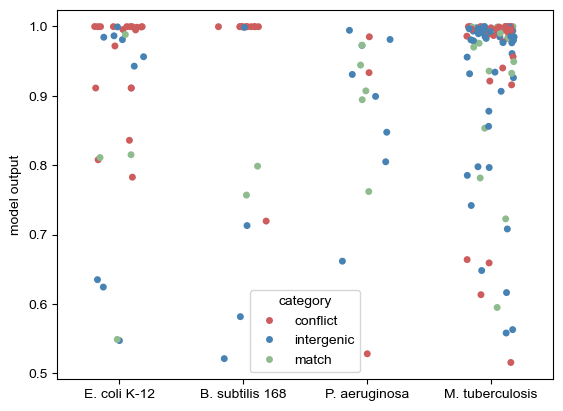

In [38]:
def figure_1(pred_df:pd.DataFrame, model_label:int=0):

    pred_df = pred_df[pred_df.model_label == model_label]
    
    fig = plt.figure()
    ax = fig.add_subplot(xlim=(0.5, 1))

    ax_df = pred_df[[f'model_output_{model_label}', 'genome_id']].copy()
    ax_df['model_organism_name'] = ax_df.genome_id.replace(model_organism_names)
    ax_df['length'] = pred_df.query_length // 3
    ax_df['category'] = pred_df.category

    sns.stripplot(data=ax_df, jitter=0.2, x='model_organism_name', y=f'model_output_{model_label}', hue='category', palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel('model output')
    plt.show()

figure_1(pred_df)



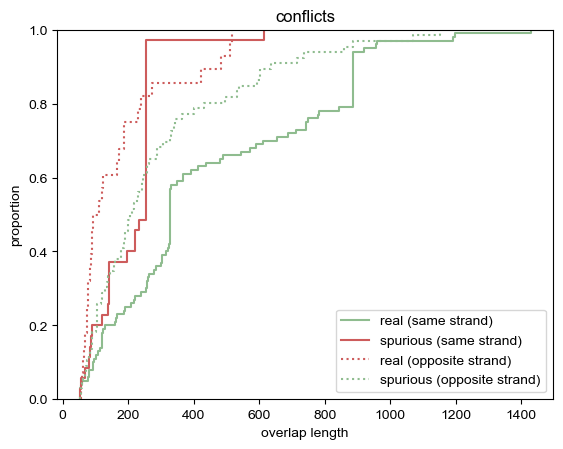

In [109]:
def figure_2(pred_df:pd.DataFrame):
    
    fig = plt.figure()
    ax = fig.add_subplot() 

    ax_df = pred_df[['category', 'overlap_length', 'top_hit_overlap_fraction', 'model_label', 'same_strand']].copy()
    ax_df = ax_df[(ax_df.category == 'conflict')]
    ax_df['model_label'] = ax_df.model_label.replace({0:'spurious', 1:'real'})
    palette = {'real':'darkseagreen', 'spurious':'indianred'}

    sns.ecdfplot(data=ax_df[ax_df.same_strand], x='overlap_length', hue='model_label', ax=ax, palette=palette)
    sns.ecdfplot(data=ax_df[~ax_df.same_strand], x='overlap_length', linestyle=':', palette=palette, hue='model_label', ax=ax)
    # sns.ecdfplot(data=ax_df[ax_df.same_strand], x='top_hit_overlap_fraction', hue='model_label', ax=ax, palette=palette)
    # sns.ecdfplot(data=ax_df[~ax_df.same_strand], x='top_hit_overlap_fraction', linestyle=':', palette=palette, hue='model_label', ax=ax)

    ax.legend(['real (same strand)', 'spurious (same strand)', 'real (opposite strand)', 'spurious (opposite strand)'], title='')
    ax.set_ylabel('proportion')
    ax.set_xlabel('overlap length')
    ax.set_title('conflicts')

    plt.show()

figure_2(pred_df)

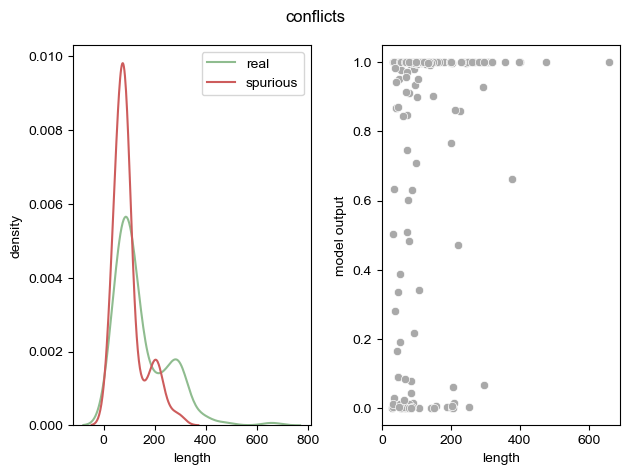

In [132]:
def figure_3(pred_df:pd.DataFrame):
    
    fig = plt.figure(layout='tight')
    plt.suptitle('conflicts')
    grid = GridSpec(ncols=2, nrows=1)
    ax_a = fig.add_subplot(grid[0]) 
    ax_b = fig.add_subplot(grid[1]) 

    ax_df = pred_df[['category', 'model_label', 'same_strand', 'model_output_0', 'model_output_1']].copy()
    ax_df['length'] = pred_df.query_length // 3
    ax_df = ax_df[(ax_df.category == 'conflict')]
    ax_df['model_label'] = ax_df.model_label.replace({0:'spurious', 1:'real'})
    palette = {'real':'darkseagreen', 'spurious':'indianred'}

    sns.kdeplot(data=ax_df, x='length', hue='model_label', ax=ax_a, palette=palette, common_norm=False)
    ax_a.legend(['real', 'spurious'], title='')
    ax_a.set_ylabel('density')
    ax_a.set_xlabel('length')

    sns.scatterplot(data=ax_df, x='length', y='model_output_1', color='darkgray', ax=ax_b)
    ax_b.set_ylabel('model output')

    plt.show()

figure_3(pred_df)

In [134]:
pred_df[(pred_df.category == 'match') & (pred_df.model_output_0 > 0.95)][['genome_id', 'query_length', 'n_hits', 'n_hits_same_strand', 'top_hit_product', 'top_hit_evidence_type', 'top_hit_evidence_details', 'top_hit_inference', 'reason']]

,genome_id,query_length,n_hits,n_hits_same_strand,top_hit_product,top_hit_evidence_type,top_hit_evidence_details,top_hit_inference,reason
id,,,,,,,,,
NC_000913.3_1397,GCF_000005845.2,168,3,2,putative regulatory protein MokB,none,none,none,exact match with NP_415937.1
NC_002516.2_4928,GCF_000006765.1,219,1,1,hypothetical protein,none,none,none,exact match with NP_253513.1
NC_000962.3_415,GCF_000195955.2,405,1,1,hypothetical protein,none,none,none,exact match with NP_214909.1
NC_000962.3_1349,GCF_000195955.2,369,2,1,hypothetical protein,none,none,none,alignment score 1.0 with YP_177642.1
NC_000962.3_1412,GCF_000195955.2,273,1,1,hypothetical protein,experiment,Mass spectrometry[PMID:14595687],none,alignment score 1.0 with NP_215867.1
NC_000962.3_1598,GCF_000195955.2,441,1,1,polyketide synthase associated protein PapA,experiment,Mass spectrometry[PMID:21085642],none,alignment score 1.0 with NP_216044.1
NC_000962.3_1910,GCF_000195955.2,258,1,1,hypothetical protein,none,none,none,exact match with NP_216347.1
NC_000962.3_2042,GCF_000195955.2,615,2,1,hypothetical protein,none,none,none,exact match with NP_216474.1
NC_000962.3_2117,GCF_000195955.2,309,1,1,hypothetical protein,none,none,none,alignment score 1.0 with NP_216539.1


In [64]:
# rbs_df = pd.concat([FASTAFile(f'../data/proteins/{genome_id}_protein.faa').to_df().assign(genome_id=genome_id) for genome_id in model_organism_genome_ids])

# rbs_df = pred_df[pred_df.model_label == 0].merge(rbs_df, left_index=True, right_index=True, how='left')
# rbs_df.value_counts(['rbs_motif', 'category'])

In [20]:
blast_file = BLASTJsonFile('../data/model_organism_spurious_blast.json')

pred_df[pred_df.index.isin(blast_file.no_hits)]

,model_label,model_output_0,model_output_1,model_name,n_hits,n_hits_same_strand,n_hits_opposite_strand,n_hits_in_frame,top_hit_feature,top_hit_contig_id,...,query_overlap_fraction,exact_match,in_frame,in_frame_c_terminus,in_frame_n_terminus,genome_id,category,pseudo,reason,auto
id,,,,,,,,,,,,,,,,,,,,,
NC_000913.3_226,0,0.980982,0.019018,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000005845.2,intergenic,False,no InterProScan hit,True
NC_000913.3_385,0,0.624389,0.375611,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000005845.2,intergenic,False,no InterProScan hit,True
NC_000913.3_3430,0,0.956340,0.043660,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000005845.2,intergenic,False,no InterProScan hit,True
NC_000913.3_4188,0,0.999337,0.000663,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000005845.2,intergenic,False,no InterProScan hit,True
NC_000913.3_4199,0,0.942753,0.057247,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000005845.2,intergenic,False,no InterProScan hit,True
NC_000964.3_1368,0,0.713013,0.286986,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000009045.1,intergenic,False,no InterProScan hit,True
NC_000964.3_2176,0,0.581758,0.418242,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000009045.1,intergenic,False,no InterProScan hit,True
NC_000964.3_2812,0,0.998549,0.001451,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000009045.1,intergenic,False,no InterProScan hit,True
NC_002516.2_625,0,0.661714,0.338286,campylobacterota_esm_650m_gap_v2,0,0,0,0,none,none,...,0.0,False,False,False,False,GCF_000006765.1,intergenic,False,no InterProScan hit,True


In [ ]:


# blast_df = blast_df[blast_df.e_value < 1e-5]
# blast_df['subject_description'] = ['conserved' if ('conserved' in description.lower()) else description for description in blast_df.subject_description]
# blast_df['subject_description'] = ['uncharacterized' if ('uncharacterised' in description.lower()) else description for description in blast_df.subject_description]
# blast_df['subject_description'] = ['hypothetical protein' if ('hypothetical protein' in description.lower()) else description for description in blast_df.subject_description]
# blast_df['subject_description'] = ['transposase' if ('transposase' in description) else description for description in blast_df.subject_description]
# # print(list(blast_df.subject_description.value_counts().index))
# blast_df.subject_description.value_counts()

No hits for query NC_000913.3_226.
No hits for query NC_000913.3_385.
No hits for query NC_000913.3_3430.
No hits for query NC_000913.3_4188.
No hits for query NC_000913.3_4199.
No hits for query NC_000964.3_1368.
No hits for query NC_000964.3_2176.
No hits for query NC_000964.3_2812.
No hits for query NC_002516.2_625.
No hits for query NC_002516.2_2299.
No hits for query NC_002516.2_2938.
No hits for query NC_002516.2_4690.
No hits for query NC_002516.2_4945.
No hits for query NC_000962.3_10.
No hits for query NC_000962.3_100.
No hits for query NC_000962.3_209.
No hits for query NC_000962.3_703.
No hits for query NC_000962.3_928.
No hits for query NC_000962.3_1117.
No hits for query NC_000962.3_1419.
No hits for query NC_000962.3_1503.
No hits for query NC_000962.3_1508.
No hits for query NC_000962.3_1780.
No hits for query NC_000962.3_1966.
No hits for query NC_000962.3_2050.
No hits for query NC_000962.3_2531.
No hits for query NC_000962.3_2745.
No hits for query NC_000962.3_3004.
N

subject_description
hypothetical protein                                              4404
uncharacterized                                                    719
transposase                                                        306
conserved                                                          163
VRR-NUC domain-containing protein [Pseudomonas aeruginosa]          88
                                                                  ... 
prophage PhiRv1 protein [Mycobacterium tuberculosis UT0087]          1
prophage PhiRv1 protein [Mycobacterium tuberculosis MAL010136]       1
prophage PhiRv1 protein [Mycobacterium tuberculosis UT0040]          1
prophage PhiRv1 protein [Mycobacterium tuberculosis XTB13-104]       1
prophage PhiRv1 protein [Mycobacterium tuberculosis M1309]           1
Name: count, Length: 394, dtype: int64

In [81]:
blast['BlastOutput2'][0]['report']['results']['search'].keys()

dict_keys(['query_id', 'query_title', 'query_len', 'hits', 'stat', 'message'])